In [1]:
import sys, os, time, shutil, random
from pathlib import Path
if '_cwd' not in locals():
    _cwd = os.getcwd()
    os.chdir(Path(_cwd)/'..')

%load_ext autoreload
%autoreload 2
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from tabulate import tabulate
import matplotlib.patches as mpatches
from tqdm.notebook import tqdm
from scipy import misc, signal

from sklearn.neighbors import NearestNeighbors
import networkx as nx
import cv2
import random
import ctypes
from scipy.signal import convolve2d, correlate2d
import ipywidgets as widgets
from IPython.display import display, clear_output
from collections import Counter
import io

import scipy.sparse as sp
from scipy.optimize import linear_sum_assignment

import omnifig as fig
from omnibelt import load_yaml, save_yaml, multi_index

from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.segmentation import *
from skimage.segmentation import watershed, expand_labels
from skimage.morphology import closing, square, dilation
from skimage.color import label2rgb
from PIL import Image
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
fig.initialize()
from src.v3 import *

In [2]:
root = Path(r'C:\Users\anwan\OneDrive\Khan\projects\digi-diplo\extra\v3')
root = Path(r'C:\Users\anwan\OneDrive\Khan\projects\digi-diplo\extra\v3\world')

In [45]:
_imgsize = (6,6)
_dpi = 300
def showx(im, cover=None):
    fg, ax = plt.subplots(figsize=_imgsize,)# dpi=_dpi)
    
    try:
        plt.imshow(im.astype(int))
        if cover is not None:
            plt.imshow(cover%1000, alpha=0., zorder=10)
    except ValueError:
        plt.imshow(im)
    
    plt.axis('off')
    plt.subplots_adjust(0,0,1,1)

def highlight(rgb, mask, opacity=0.2):
    alpha = np.zeros_like(mask).astype(np.uint8)
    
    img = rgb.astype(np.uint8)
    
    alpha[mask!=0] = 255
    alpha[mask==0] = int(255*opacity)
    
    H,W,C = img.shape
    
    if C == 4:
        img[...,-1] = alpha
    else:
        img = np.concatenate([img, alpha.reshape(H,W,1)],-1)
    return showx(img)
    

<IPython.core.display.Javascript object>


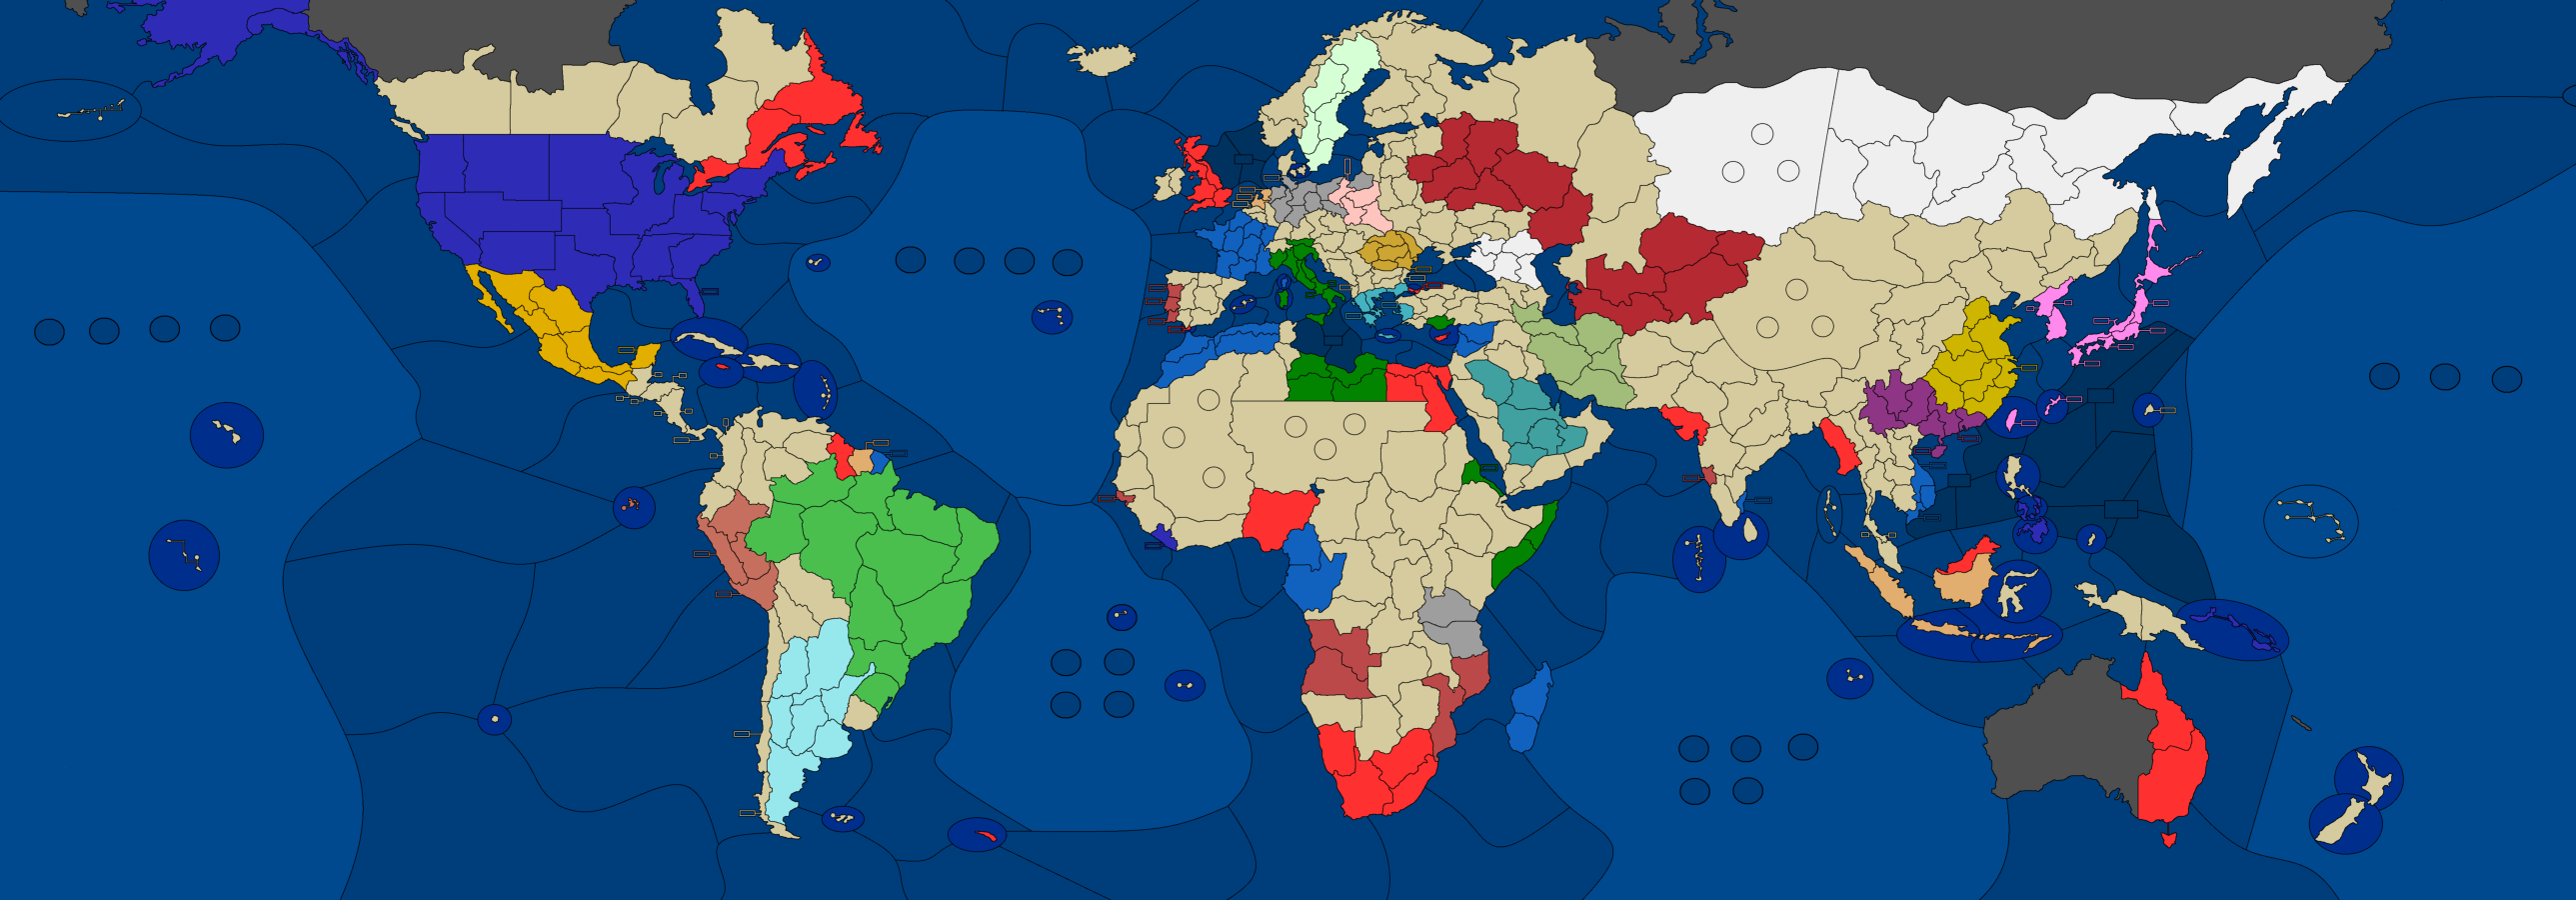

In [48]:
color_path = root / 'borders.png'
color_path = root / 'renderbase.png'

im = Image.open(color_path).convert('RGBA')
im = np.asarray(im)

rgb = im[...,:3]
# rgb = rgb[::2,::2]
H, W, _ = rgb.shape
fgh = 6
_imgsize = (W/H*fgh, fgh)
_dpi = H / _imgsize[1]

# show(im)
showx(rgb);

In [5]:
# def assign_dots(lbls, dots, cats=None):
#     infos = regionprops(label(dots))
#     coords = np.array([info.centroid for info in infos])#.astype(int)
#     ys, xs = coords.astype(int).T
#     picks = lbls[ys, xs]
#     locs = [{'loc': [y,x], 'id': i+1, 'lbl': pick}
#             for i, (pick, (y,x)) in enumerate(zip(picks.tolist(), coords.tolist()))]
#     if cats is not None:
#         for loc, cat in zip(locs, cats[ys, xs].tolist()):
#             loc['cat'] = cat
#     return locs

In [35]:
tiles_path

WindowsPath('C:/Users/anwan/OneDrive/Khan/projects/digi-diplo/extra/v3/world/tiles.png')

In [49]:
tiles_path = root / 'tiles.png'

tiles = np.array(Image.open(tiles_path))
# showx(lbls)
tiles.shape

(2592, 7422)

<IPython.core.display.Javascript object>


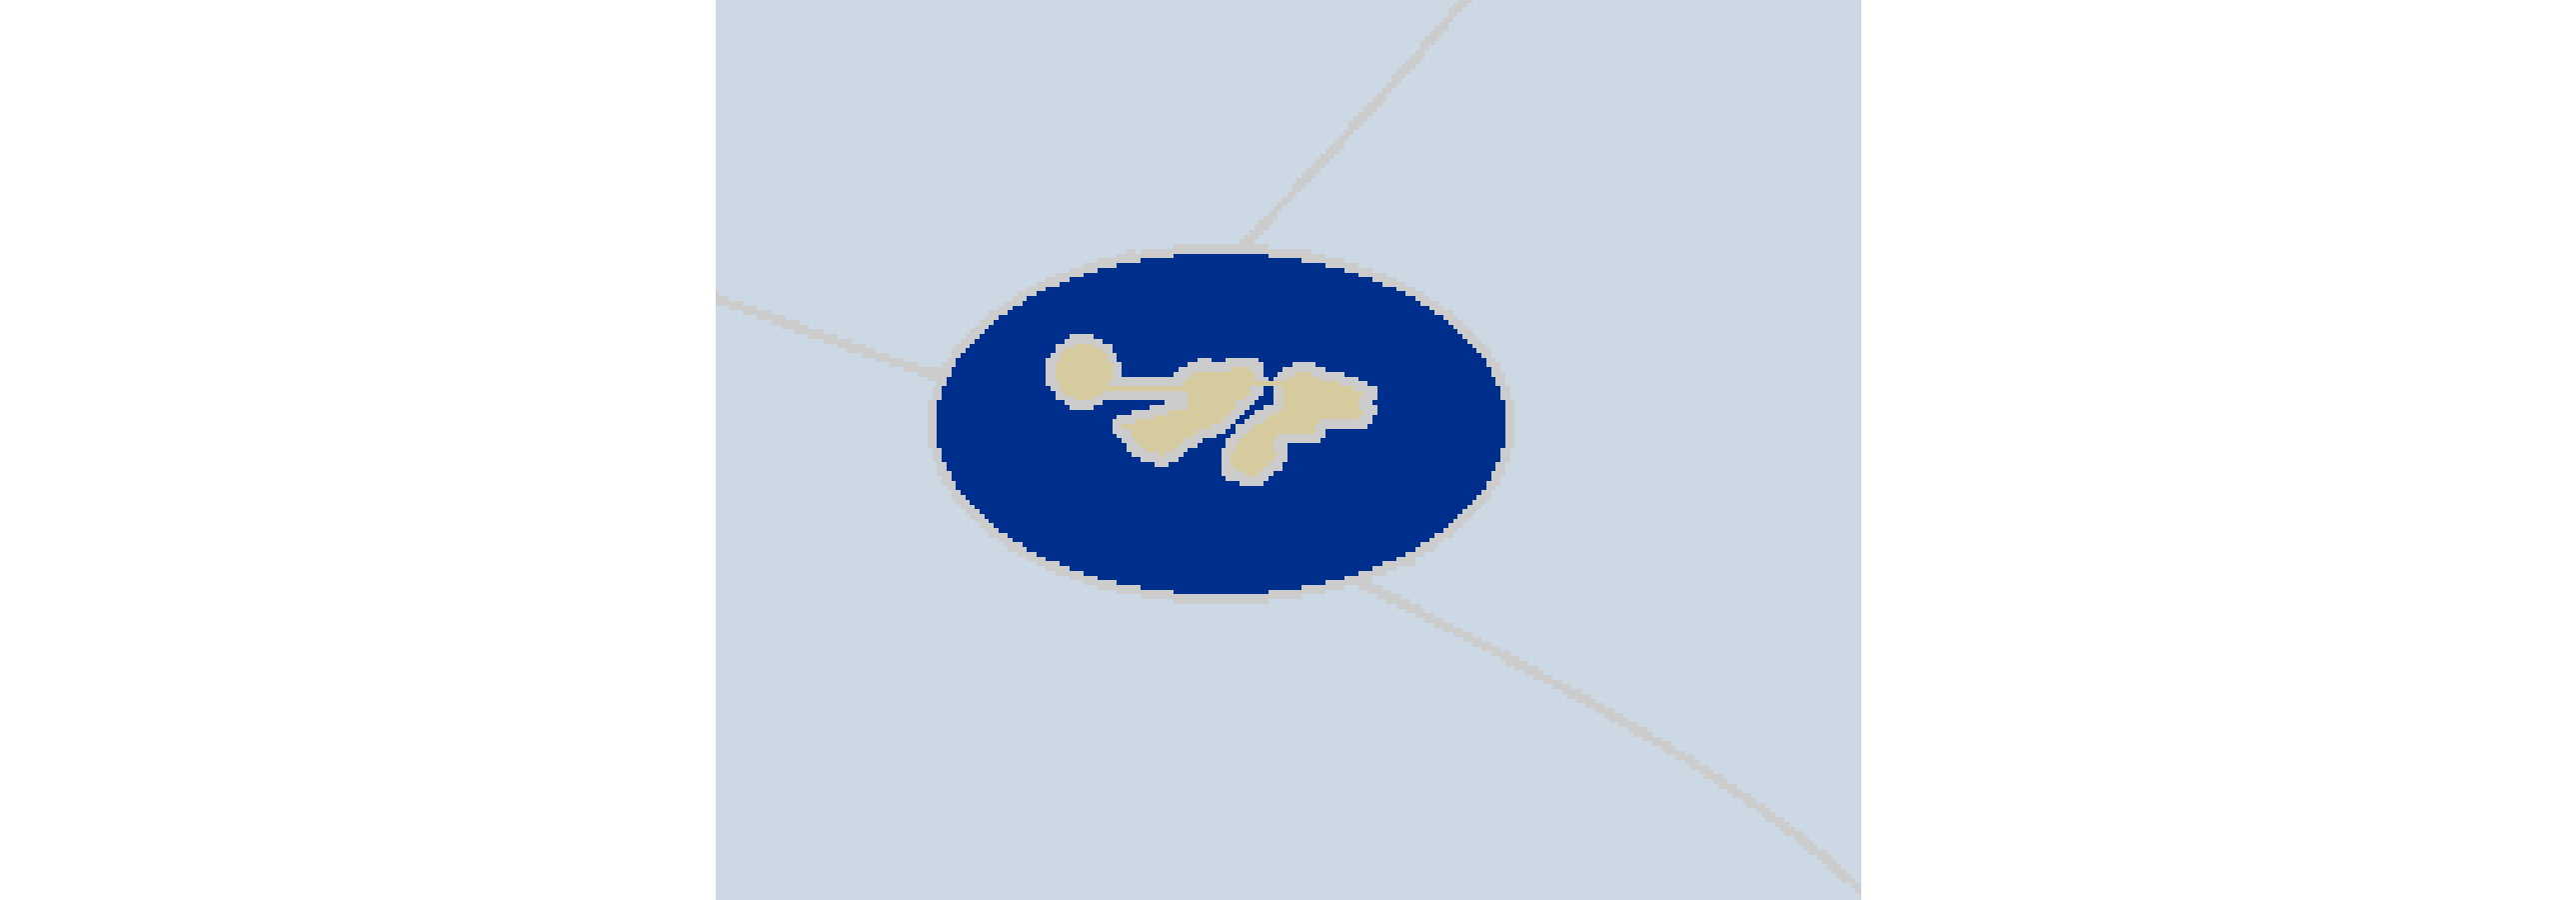

In [52]:
highlight(rgb, tiles==783);

In [36]:
regions_path = root / 'regions.png'

lbls = np.array(Image.open(regions_path))
# showx(lbls)
lbls.shape

(2592, 7422)

In [40]:
reginfo = load_yaml(root / 'regions.yaml')
len(reginfo)

624

In [37]:
regs = regionprops(lbls)
len(regs)

622

In [38]:
areas = [r.area for r in regs]
min(areas)

2

In [22]:
num_tiles = lbls.max()

In [23]:
dots_path = root / 'dotz.png'

dots = np.array(Image.open(dots_path))
dot_rgb = dots[...,:3]
dot = dots[..., -1] > 0
# showx(dot)
dot.shape

(2592, 7422)

In [24]:

def extract_color(sel):
    c = Counter(map(tuple, sel.tolist()))
    c, _ = c.most_common(1)[0]
    return c

In [25]:
# tile_colors = [extract_color(rgb[lbls==idx]) for idx in tqdm(range(1, num_tiles+1))]

100%|█████████████████████████████████████████████████| 790/790 [00:38<00:00, 20.65it/s]


In [29]:
tile_colors = [(0, 62, 123), (79, 79, 79), (46, 44, 183), (79, 79, 79), (0, 62, 123), (0, 62, 123), (0, 62, 123), (0, 62, 123), (79, 79, 79), (0, 62, 123), (0, 62, 123), (0, 62, 123), (214, 203, 158), (46, 44, 183), (214, 203, 158), (214, 203, 158), (0, 62, 123), (0, 62, 123), (254, 48, 48), (215, 255, 214), (214, 203, 158), (0, 62, 123), (0, 62, 123), (214, 203, 158), (214, 203, 158), (0, 62, 123), (0, 62, 123), (0, 62, 123), (0, 62, 123), (0, 62, 123), (215, 255, 214), (214, 203, 158), (0, 62, 123), (0, 62, 123), (214, 203, 158), (214, 203, 158), (214, 203, 158), (214, 203, 158), (239, 239, 239), (0, 62, 123), (239, 239, 239), (239, 239, 239), (0, 62, 123), (0, 62, 123), (214, 203, 158), (214, 203, 158), (0, 62, 123), (0, 62, 123), (0, 62, 123), (215, 255, 214), (239, 239, 239), (239, 239, 239), (0, 62, 123), (214, 203, 158), (214, 203, 158), (254, 48, 48), (215, 255, 214), (214, 203, 158), (0, 62, 123), (214, 203, 158), (0, 73, 142), (181, 41, 50), (0, 62, 123), (0, 62, 123), (0, 62, 123), (0, 62, 123), (0, 62, 123), (181, 41, 50), (0, 50, 96), (214, 203, 158), (239, 239, 239), (239, 239, 239), (214, 203, 158), (239, 239, 239), (0, 62, 123), (46, 44, 183), (0, 62, 123), (0, 50, 96), (239, 239, 239), (46, 44, 183), (46, 44, 183), (239, 239, 239), (254, 48, 48), (0, 62, 123), (214, 203, 158), (215, 255, 214), (0, 62, 123), (46, 44, 183), (46, 44, 183), (181, 41, 50), (0, 62, 123), (214, 203, 158), (214, 203, 158), (193, 46, 117), (0, 62, 123), (239, 239, 239), (0, 62, 123), (181, 41, 50), (0, 50, 96), (214, 203, 158), (254, 48, 48), (181, 41, 50), (254, 197, 190), (0, 62, 123), (0, 62, 123), (0, 50, 96), (0, 62, 123), (254, 48, 48), (254, 48, 48), (239, 239, 239), (239, 239, 239), (0, 46, 140), (0, 73, 142), (0, 46, 140), (214, 203, 158), (0, 46, 140), (239, 239, 239), (214, 203, 158), (214, 203, 158), (0, 62, 123), (181, 41, 50), (214, 203, 158), (158, 158, 158), (0, 62, 123), (158, 158, 158), (214, 203, 158), (0, 62, 123), (0, 62, 123), (0, 62, 123), (158, 158, 158), (0, 62, 123), (254, 48, 48), (158, 158, 158), (254, 197, 190), (0, 62, 123), (214, 203, 158), (181, 41, 50), (214, 203, 158), (158, 158, 158), (0, 62, 123), (226, 174, 111), (0, 62, 123), (158, 158, 158), (254, 48, 48), (214, 203, 158), (46, 44, 183), (0, 73, 142), (158, 158, 158), (0, 62, 123), (46, 44, 183), (46, 44, 183), (46, 44, 183), (0, 62, 123), (226, 174, 111), (0, 62, 123), (254, 197, 190), (0, 62, 123), (254, 48, 48), (0, 62, 123), (0, 62, 123), (254, 197, 190), (158, 158, 158), (214, 203, 158), (0, 62, 123), (214, 203, 158), (0, 62, 123), (0, 62, 123), (214, 203, 158), (0, 62, 123), (214, 203, 158), (0, 62, 123), (214, 203, 158), (214, 203, 158), (158, 158, 158), (214, 203, 158), (0, 62, 123), (0, 62, 123), (214, 203, 158), (46, 44, 183), (214, 203, 158), (0, 62, 123), (17, 97, 191), (214, 203, 158), (214, 203, 158), (0, 62, 123), (214, 203, 158), (181, 41, 50), (214, 203, 158), (214, 203, 158), (17, 97, 191), (255, 137, 237), (17, 97, 191), (214, 203, 158), (214, 203, 158), (214, 203, 158), (214, 203, 158), (214, 203, 158), (17, 97, 191), (17, 97, 191), (214, 203, 158), (214, 203, 158), (214, 203, 158), (239, 239, 239), (205, 165, 50), (181, 41, 50), (205, 165, 50), (46, 44, 183), (214, 203, 158), (0, 62, 123), (239, 239, 239), (46, 44, 183), (46, 44, 183), (17, 97, 191), (46, 44, 183), (214, 203, 158), (2, 132, 0), (205, 165, 50), (0, 62, 123), (214, 203, 158), (214, 203, 158), (205, 165, 50), (17, 97, 191), (2, 132, 0), (0, 62, 123), (239, 239, 239), (0, 62, 123), (214, 203, 158), (0, 62, 123), (2, 132, 0), (214, 203, 158), (0, 62, 123), (0, 62, 123), (2, 132, 0), (17, 97, 191), (0, 62, 123), (214, 203, 158), (205, 165, 50), (214, 203, 158), (239, 239, 239), (181, 41, 50), (0, 62, 123), (239, 239, 239), (181, 41, 50), (0, 46, 140), (0, 62, 123), (17, 97, 191), (214, 203, 158), (0, 62, 123), (214, 203, 158), (205, 165, 50), (0, 62, 123), (2, 132, 0), (2, 132, 0), (0, 62, 123), (226, 174, 0), (0, 62, 123), (214, 203, 158), (214, 203, 158), (0, 62, 123), (0, 62, 123), (0, 62, 123), (0, 62, 123), (214, 203, 158), (214, 203, 158), (214, 203, 158), (0, 46, 140), (214, 203, 158), (214, 203, 158), (46, 44, 183), (17, 97, 191), (0, 62, 123), (2, 132, 0), (255, 137, 237), (214, 203, 158), (214, 203, 158), (214, 203, 158), (214, 203, 158), (0, 62, 123), (0, 62, 123), (0, 62, 123), (0, 62, 123), (181, 41, 50), (0, 62, 123), (254, 48, 48), (67, 178, 193), (214, 203, 158), (0, 62, 123), (188, 73, 73), (0, 62, 123), (0, 46, 140), (226, 174, 0), (214, 203, 158), (214, 203, 158), (214, 203, 158), (0, 62, 123), (0, 62, 123), (0, 62, 123), (214, 203, 158), (214, 203, 158), (67, 178, 193), (2, 132, 0), (255, 137, 237), (0, 46, 140), (0, 46, 140), (0, 62, 123), (2, 132, 0), (0, 62, 123), (0, 62, 123), (0, 46, 140), (0, 62, 123), (0, 62, 123), (67, 178, 193), (0, 62, 123), (214, 203, 158), (214, 203, 158), (0, 46, 140), (0, 50, 96), (214, 203, 158), (206, 182, 0), (188, 73, 73), (214, 203, 158), (0, 62, 123), (0, 62, 123), (214, 203, 158), (0, 62, 123), (0, 62, 123), (214, 203, 158), (0, 62, 123), (0, 46, 140), (162, 188, 122), (0, 62, 123), (0, 62, 123), (67, 178, 193), (0, 62, 123), (214, 203, 158), (226, 174, 0), (255, 137, 237), (0, 62, 123), (214, 203, 158), (67, 178, 193), (0, 62, 123), (0, 153, 84), (214, 203, 158), (188, 73, 73), (255, 137, 237), (0, 62, 123), (0, 62, 123), (0, 62, 123), (0, 62, 123), (0, 62, 123), (162, 188, 122), (214, 203, 158), (0, 62, 123), (206, 182, 0), (0, 62, 123), (2, 132, 0), (0, 62, 123), (214, 203, 158), (0, 62, 123), (214, 203, 158), (0, 46, 140), (214, 203, 158), (214, 203, 158), (0, 50, 96), (162, 188, 122), (0, 62, 123), (214, 203, 158), (0, 62, 123), (0, 62, 123), (0, 62, 123), (214, 203, 158), (214, 203, 158), (17, 97, 191), (17, 97, 191), (0, 50, 96), (255, 137, 237), (0, 62, 123), (0, 46, 140), (0, 46, 140), (214, 203, 158), (254, 48, 48), (0, 46, 140), (226, 174, 0), (206, 182, 0), (0, 46, 140), (0, 62, 123), (0, 46, 140), (214, 203, 158), (0, 50, 96), (0, 62, 123), (0, 46, 140), (0, 50, 96), (0, 50, 96), (17, 97, 191), (17, 97, 191), (17, 97, 191), (255, 137, 237), (214, 203, 158), (254, 48, 48), (162, 188, 122), (67, 178, 193), (226, 174, 0), (255, 137, 237), (0, 50, 96), (0, 50, 96), (0, 62, 123), (0, 62, 123), (162, 188, 122), (214, 203, 158), (17, 97, 191), (0, 62, 123), (214, 203, 158), (0, 62, 123), (214, 203, 158), (226, 174, 0), (0, 46, 140), (0, 62, 123), (214, 203, 158), (0, 50, 96), (0, 62, 123), (0, 62, 123), (214, 203, 158), (206, 182, 0), (0, 62, 123), (214, 203, 158), (2, 132, 0), (214, 203, 158), (2, 132, 0), (214, 203, 158), (206, 182, 0), (0, 46, 140), (214, 203, 158), (206, 182, 0), (65, 160, 160), (0, 46, 140), (214, 203, 158), (0, 50, 96), (254, 48, 48), (0, 62, 123), (254, 48, 48), (214, 203, 158), (0, 62, 123), (0, 62, 123), (254, 48, 48), (162, 188, 122), (0, 62, 123), (226, 174, 0), (0, 62, 123), (2, 132, 0), (206, 182, 0), (214, 203, 158), (142, 54, 133), (254, 48, 48), (214, 203, 158), (254, 48, 48), (0, 62, 123), (214, 203, 158), (2, 132, 0), (0, 62, 123), (0, 62, 123), (0, 62, 123), (214, 203, 158), (0, 62, 123), (214, 203, 158), (0, 62, 123), (0, 62, 123), (0, 62, 123), (214, 203, 158), (65, 160, 160), (142, 54, 133), (0, 62, 123), (142, 54, 133), (214, 203, 158), (206, 182, 0), (214, 203, 158), (0, 50, 96), (214, 203, 158), (0, 46, 140), (214, 203, 158), (142, 54, 133), (0, 62, 123), (0, 62, 123), (0, 46, 140), (255, 137, 237), (0, 62, 123), (0, 62, 123), (0, 46, 140), (0, 62, 123), (0, 50, 96), (0, 62, 123), (214, 203, 158), (0, 62, 123), (214, 203, 158), (214, 203, 158), (214, 203, 158), (0, 46, 140), (65, 160, 160), (0, 50, 96), (214, 203, 158), (254, 48, 48), (214, 203, 158), (142, 54, 133), (214, 203, 158), (255, 137, 237), (0, 46, 140), (0, 62, 123), (0, 62, 123), (142, 54, 133), (214, 203, 158), (0, 62, 123), (214, 203, 158), (0, 62, 123), (214, 203, 158), (214, 203, 158), (254, 48, 48), (68, 163, 144), (214, 203, 158), (65, 160, 160), (0, 62, 123), (214, 203, 158), (0, 50, 96), (0, 46, 140), (0, 62, 123), (214, 203, 158), (214, 203, 158), (214, 203, 158), (0, 62, 123), (214, 203, 158), (65, 160, 160), (0, 62, 123), (214, 203, 158), (214, 203, 158), (214, 203, 158), (214, 203, 158), (214, 203, 158), (214, 203, 158), (0, 50, 96), (254, 48, 48), (0, 62, 123), (0, 62, 123), (0, 62, 123), (214, 203, 158), (226, 174, 111), (0, 62, 123), (0, 62, 123), (65, 160, 160), (214, 203, 158), (214, 203, 158), (0, 62, 123), (0, 62, 123), (17, 97, 191), (214, 203, 158), (0, 62, 123), (0, 50, 96), (0, 62, 123), (0, 62, 123), (214, 203, 158), (74, 191, 78), (214, 203, 158), (0, 46, 140), (0, 62, 123), (17, 97, 191), (214, 203, 158), (0, 46, 140), (2, 132, 0), (214, 203, 158), (74, 191, 78), (214, 203, 158), (214, 203, 158), (0, 62, 123), (188, 73, 73), (0, 62, 123), (214, 203, 158), (214, 203, 158), (0, 62, 123), (0, 62, 123), (0, 50, 96), (214, 203, 158), (214, 203, 158), (0, 50, 96), (0, 62, 123), (214, 203, 158), (0, 62, 123), (0, 62, 123), (214, 203, 158), (214, 203, 158), (0, 62, 123), (0, 62, 123), (214, 203, 158), (17, 97, 191), (0, 73, 142), (214, 203, 158), (0, 62, 123), (0, 46, 140), (0, 50, 96), (214, 203, 158), (254, 48, 48), (0, 46, 140), (74, 191, 78), (214, 203, 158), (198, 111, 94), (188, 73, 73), (0, 62, 123), (17, 97, 191), (0, 62, 123), (0, 62, 123), (214, 203, 158), (0, 46, 140), (0, 46, 140), (0, 62, 123), (46, 44, 183), (0, 46, 140), (0, 73, 142), (0, 46, 140), (0, 62, 123), (74, 191, 78), (214, 203, 158), (74, 191, 78), (2, 132, 0), (0, 50, 96), (0, 46, 140), (17, 97, 191), (0, 46, 140), (0, 50, 96), (214, 203, 158), (74, 191, 78), (0, 50, 96), (0, 46, 140), (198, 111, 94), (214, 203, 158), (214, 203, 158), (0, 50, 96), (0, 62, 123), (0, 46, 140), (46, 44, 183), (0, 46, 140), (214, 203, 158), (0, 46, 140), (17, 97, 191), (46, 44, 183), (74, 191, 78), (0, 46, 140), (0, 46, 140), (214, 203, 158), (0, 62, 123), (214, 203, 158), (0, 62, 123), (0, 62, 123), (198, 111, 94), (214, 203, 158), (0, 62, 123), (0, 62, 123), (214, 203, 158), (254, 48, 48), (0, 62, 123), (214, 203, 158), (0, 62, 123), (214, 203, 158), (2, 132, 0), (214, 203, 158), (0, 62, 123), (0, 62, 123), (0, 62, 123), (0, 62, 123), (0, 73, 142), (226, 174, 111), (214, 203, 158), (0, 62, 123), (17, 97, 191), (0, 62, 123), (214, 203, 158), (226, 174, 111), (214, 203, 158), (0, 46, 140), (0, 62, 123), (0, 46, 140), (198, 111, 94), (0, 62, 123), (226, 174, 111), (74, 191, 78), (0, 62, 123), (214, 203, 158), (0, 62, 123), (0, 62, 123), (74, 191, 78), (0, 62, 123), (214, 203, 158), (214, 203, 158), (158, 158, 158), (0, 62, 123), (0, 62, 123), (0, 62, 123), (0, 62, 123), (214, 203, 158), (0, 62, 123), (0, 62, 123), (214, 203, 158), (214, 203, 158), (0, 46, 140), (0, 46, 140), (0, 62, 123), (0, 46, 140), (214, 203, 158), (46, 44, 183), (0, 46, 140), (214, 203, 158), (0, 62, 123), (0, 62, 123), (0, 62, 123), (151, 232, 237), (0, 62, 123), (226, 174, 111), (188, 73, 73), (158, 158, 158), (0, 46, 140), (0, 62, 123), (214, 203, 158), (226, 174, 111), (0, 62, 123), (151, 232, 237), (92, 237, 66), (74, 191, 78), (0, 62, 123), (214, 203, 158), (0, 62, 123), (188, 73, 73), (0, 62, 123), (0, 62, 123), (188, 73, 73), (254, 48, 48), (79, 79, 79), (0, 46, 140), (17, 97, 191), (151, 232, 237), (214, 203, 158), (0, 46, 140), (74, 191, 78), (188, 73, 73), (214, 203, 158), (214, 203, 158), (214, 203, 158), (0, 62, 123), (0, 62, 123), (151, 232, 237), (214, 203, 158), (214, 203, 158), (151, 232, 237), (214, 203, 158), (0, 46, 140), (0, 62, 123), (0, 62, 123), (17, 97, 191), (214, 203, 158), (79, 79, 79), (151, 232, 237), (0, 62, 123), (254, 48, 48), (0, 62, 123), (0, 62, 123), (254, 48, 48), (254, 48, 48), (0, 62, 123), (0, 62, 123), (0, 62, 123), (0, 62, 123), (0, 62, 123), (151, 232, 237), (254, 48, 48), (0, 46, 140), (0, 46, 140), (0, 46, 140), (214, 203, 158), (254, 48, 48), (193, 46, 117), (214, 203, 158), (0, 62, 123), (0, 62, 123), (0, 62, 123), (0, 62, 123), (0, 46, 140), (214, 203, 158), (0, 62, 123), (0, 46, 140), (0, 62, 123), (0, 62, 123), (0, 62, 123), (0, 46, 140), (254, 48, 48), (0, 46, 140), (0, 62, 123)]

In [26]:

bases = assign_dots(lbls, dot, dot_rgb)
for base in bases:
    # y, x = base['loc']
    base['color'] = tile_colors[base['lbl']-1]
    base['lbl'] = [base['lbl']]
print(bases[0])
len(bases)

[  3   6   8   4  14   7  15   9  16   1  24  20   5  13  47  36  31  17
  21  12  19  38  46  32  37  25  35  40  54  18  39  55  42  65  43  60
  50  45  71  57  51  73  56  70  69  62  68  75  77  84  85  52  83  86
  99  59  78  58  92  49  80  59  93  95 100 104  98 110 115  81  67 101
 106  97 111  74 116  82 109  88  64  53 102  72 127  76 123 125  90 118
  59 119 140 130 122 133 132 139 141 103 121 134 126 144  96 117 146 154
 158 148 143 162 136 165 135  89 156 172 168 151 174 186 170 150 153 182
 161 131 180 175 176 184 137 173 190 145 196 179 194 193 189 198 152 192
 195 138 204 208 178 199 200 202 216 206 215 203 210 197 187 213 205 163
 188 209 223 217 221 166 220 219 212 233 207 228 234 225 232 226 249 222
 237 229 235 244 231 250 211 239 238 227 246 247 191 214 164 253 258 257
 242 251 230 185 254 224 129 241 218 252 263 265 236 243 270 264 267 256
 274 272 240 285 284 292 275 286 277 288 299 255 300 298 301 293 268 276
 294 306 269 316 327 273 320 312 315 302 291 248 27

623

In [19]:
man = [lbl for base in bases for lbl in base['lbl']]
len(man), len(set(man))

(623, 619)

In [15]:
bases[:15]

[{'loc': [35.60344827586207, 647.6034482758621],
  'id': 1,
  'lbl': [3],
  'cat': [0, 255, 33],
  'color': (46, 44, 183)},
 {'loc': [39.60344827586207, 3108.603448275862],
  'id': 2,
  'lbl': [6],
  'cat': [0, 255, 255],
  'color': (0, 62, 123)},
 {'loc': [56.60344827586207, 4434.603448275862],
  'id': 3,
  'lbl': [8],
  'cat': [0, 255, 255],
  'color': (0, 62, 123)},
 {'loc': [59.60344827586207, 1463.603448275862],
  'id': 4,
  'lbl': [4],
  'cat': [255, 21, 0],
  'color': (79, 79, 79)},
 {'loc': [72.60344827586206, 863.6034482758621],
  'id': 5,
  'lbl': [14],
  'cat': [0, 255, 33],
  'color': (46, 44, 183)},
 {'loc': [81.60344827586206, 3568.603448275862],
  'id': 6,
  'lbl': [7],
  'cat': [0, 255, 255],
  'color': (0, 62, 123)},
 {'loc': [82.60344827586206, 3963.603448275862],
  'id': 7,
  'lbl': [15],
  'cat': [0, 255, 33],
  'color': (214, 203, 158)},
 {'loc': [92.60344827586206, 5336.603448275862],
  'id': 8,
  'lbl': [9],
  'cat': [255, 21, 0],
  'color': (79, 79, 79)},
 {'loc

In [18]:
# im = Image.open(color_path).convert('RGBA')
# im = np.asarray(im)
# rgb = im[...,:3]
# rgb = rgb[::2,::2]

In [19]:
from matplotlib.figure import figaspect
scale = 1.

<IPython.core.display.Javascript object>


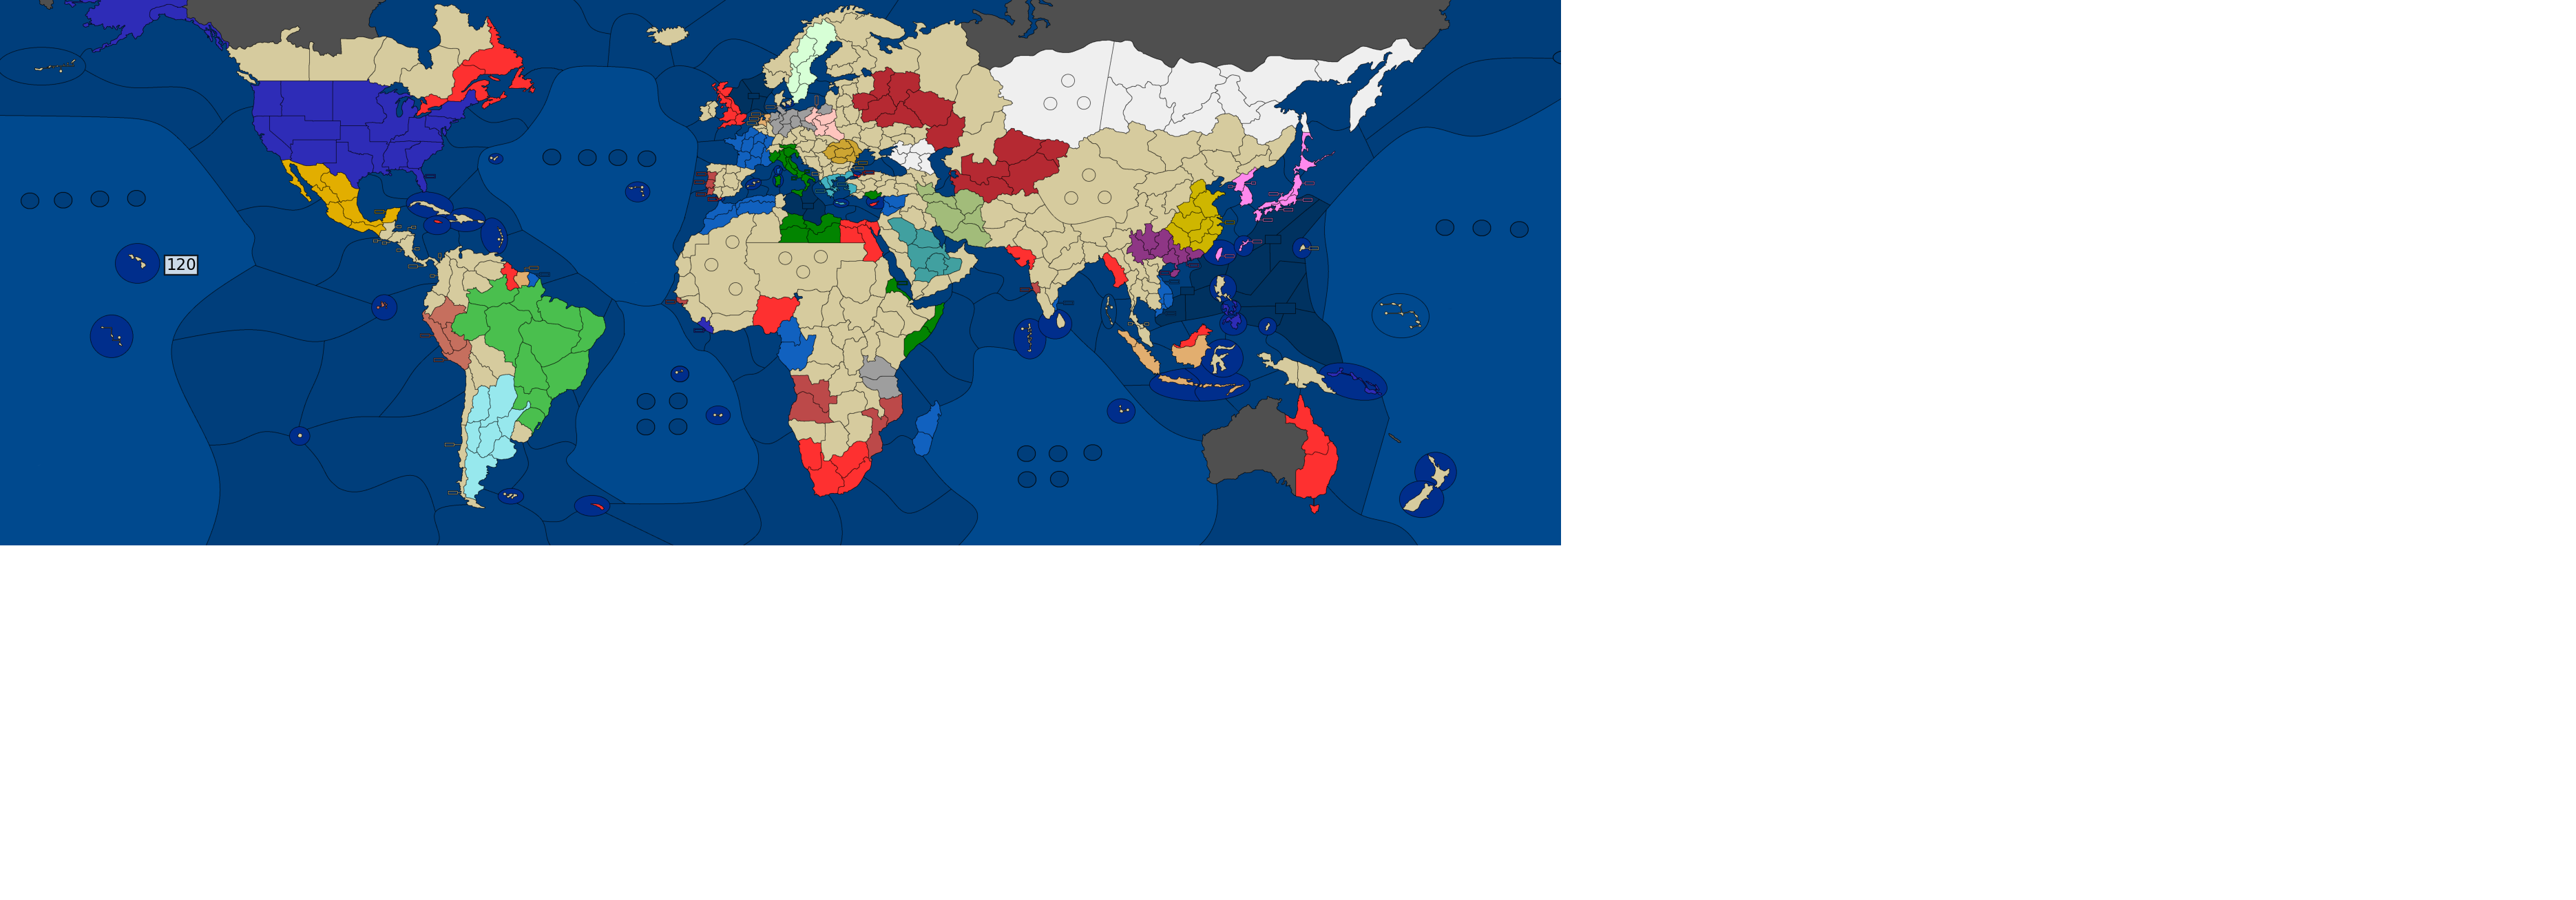

In [20]:
H, W, _ = im.shape
aw, ah = figaspect(H / W)
aw, ah = scale * aw, scale * ah
figsize = aw, ah

plt.figure(figsize=figsize)
plt.imshow(im);
plt.axis('off')
plt.subplots_adjust(0,0,1,1);

In [21]:
t = plt.text(860,1260,'120', va='center', ha='center',
#              transform=ax.transAxes,
             bbox=dict(facecolor='1', edgecolor='0', alpha=0.8, pad=1.)
             )
# t.set_bbox(dict(facecolor='1', alpha=0.8, edgecolor='0'), pad=-1);

In [112]:
root = r'C:\Users\anwan\OneDrive\Khan\projects\digi-diplo\extra\v3\tests'
root = Path(root)
path = root / 'regions.png'

In [115]:
regim = np.array(Image.open(path))
regim.shape

(2001, 1986)

<IPython.core.display.Javascript object>


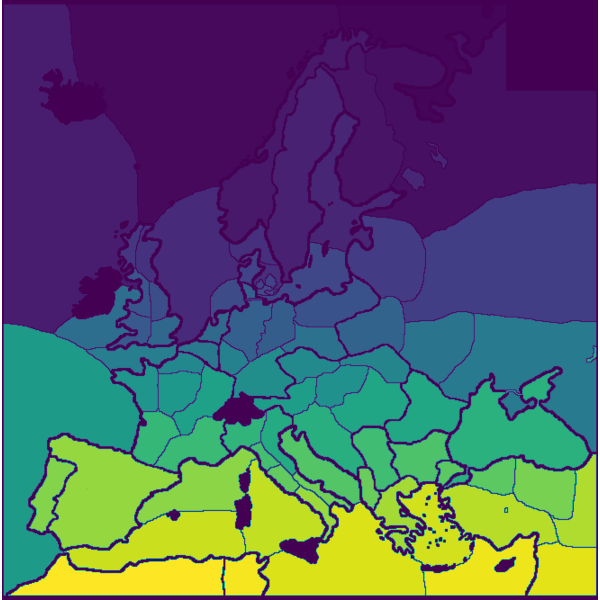

In [116]:
showx(regim)

In [80]:
border_color = '#000000'
bcolor = hex_to_rgb(border_color)
bcolor

[0, 0, 0]

In [6]:
border_color = '#000000'
bcolor = hex_to_rgb(border_color) if isinstance(border_color, str) else border_color
bcolor = np.array(bcolor).reshape(1,1,-1)

border = np.abs(rgb - bcolor).sum(-1) == 0
lbls = label(fill_diagonals(border))[1::3, 1::3]

In [7]:
g = extract_neighbors(lbls, pbar=tqdm)

  0%|          | 0/166 [00:00<?, ?it/s]

In [8]:
tmap = generate_tiles(rgb, g=g, 
#                       path=(root/'tiles.png'), 
                      pbar=tqdm)
tmap.shape

(1001, 993, 3)

<IPython.core.display.Javascript object>


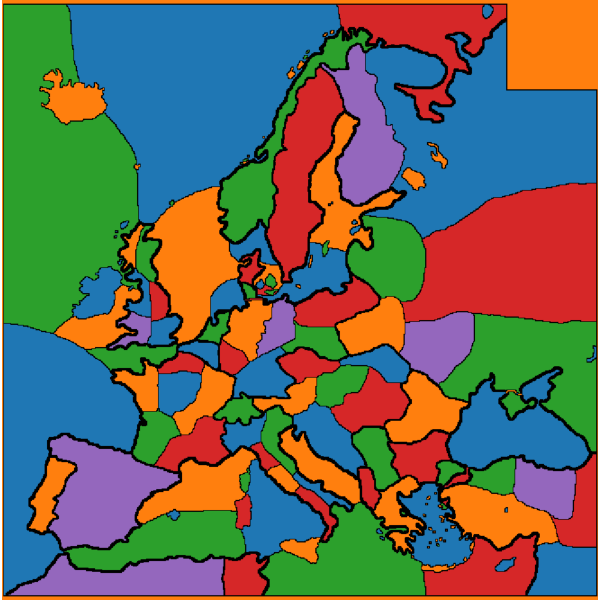

In [9]:
showx(tmap)

In [10]:
cats_path = root / 'cats.png'

cat_im = Image.open(cats_path).convert('RGBA')
cat_im = np.asarray(cat_im)
crgb = cat_im[...,:3]
crgb = crgb[::2,::2]
crgb.shape

(1001, 993, 3)

In [11]:
ccs = set(map(tuple,crgb.reshape(-1, 3).tolist()))
ccs.discard((0,0,0))
ccs

{(0, 255, 33), (0, 255, 255)}

<IPython.core.display.Javascript object>


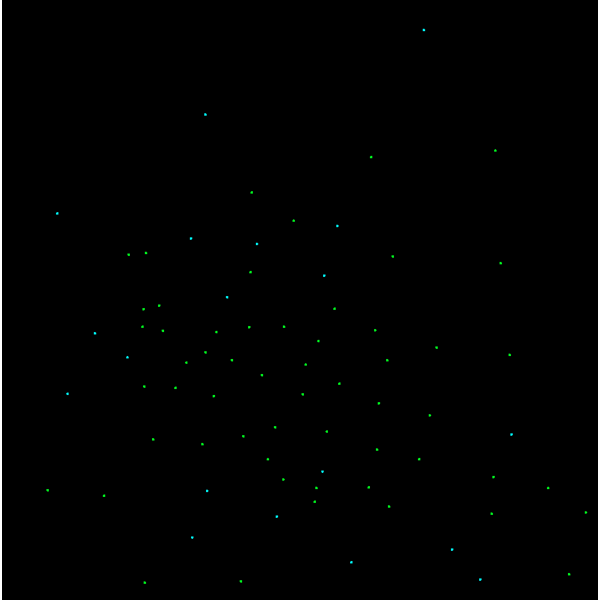

In [12]:
showx(crgb)

<IPython.core.display.Javascript object>


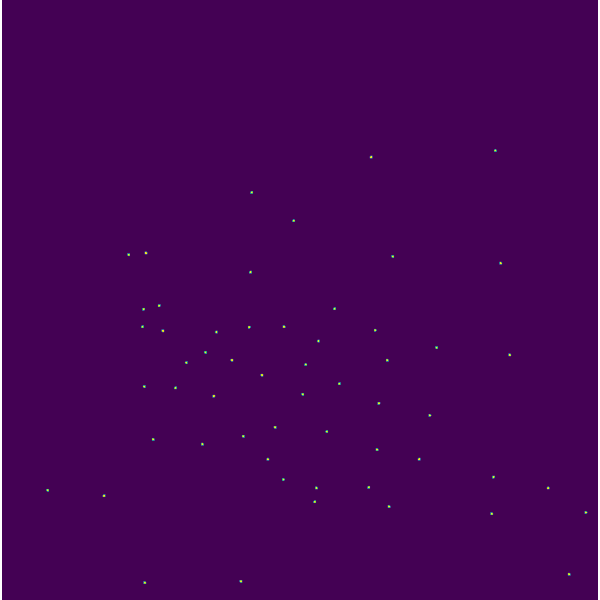

In [18]:
clbl = label(crgb.sum(-1))
dinfo = regionprops(clbl)
dinfo.insert(0,[])
color = (0, 255, 33)
c = np.array(color).reshape(1,1,-1)
sel = (crgb - c).sum(-1) == 0
showx(sel)

In [20]:
dinfo[3].centroid

(250.71428571428572, 821.5)

In [16]:
set(clbl[sel].tolist())

{3,
 4,
 5,
 7,
 11,
 12,
 13,
 14,
 15,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 28,
 29,
 30,
 31,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 42,
 43,
 44,
 45,
 46,
 47,
 49,
 50,
 51,
 52,
 53,
 54,
 56,
 57,
 58,
 59,
 60,
 61,
 63,
 64,
 65,
 66,
 67,
 72,
 74,
 75}

In [30]:
import random
import numpy as np
from collections import Counter

In [31]:
splits = [12, 15, 20, 25]
names = ['orange', 'yellow', 'green', 'blue']
N = sum(splits)
N

72

In [32]:
nums = np.array([2,3,4,5])
wts = np.array([0.2, 0.3, 0.4, 0.1])

In [33]:
N / nums * wts

array([7.2 , 7.2 , 7.2 , 1.44])

In [34]:
res = [names[i] for i,n in enumerate(splits) for _ in range(n)]

In [35]:
groups = []
# while True:
#     pass

In [36]:
nums = np.array(random.choices([2,3,4,5], weights=[0.2, 0.4, 0.3, 0.1], k=100))

In [37]:
tots = nums[np.cumsum(nums)<72]
len(tots)

20

In [38]:
cards = [random.choices(names, weights=splits, k=n) for n in tots]
cards

[['yellow', 'yellow', 'green'],
 ['orange', 'yellow'],
 ['blue', 'yellow', 'green'],
 ['blue', 'blue', 'blue', 'yellow', 'green'],
 ['green', 'green', 'orange'],
 ['green', 'blue', 'yellow'],
 ['orange', 'orange', 'green', 'orange'],
 ['green', 'orange', 'blue', 'green'],
 ['green', 'green', 'blue'],
 ['green', 'yellow', 'blue'],
 ['orange', 'yellow'],
 ['orange', 'blue', 'blue'],
 ['yellow', 'green', 'blue', 'yellow'],
 ['orange', 'yellow', 'orange', 'blue'],
 ['green', 'blue', 'green', 'green', 'orange'],
 ['yellow', 'green', 'green'],
 ['blue', 'blue', 'green'],
 ['green', 'blue', 'orange', 'green'],
 ['yellow', 'blue', 'blue', 'blue'],
 ['yellow', 'blue', 'green', 'green', 'orange']]

In [39]:
Counter([x for xs in cards for x in xs])

Counter({'yellow': 14, 'green': 23, 'orange': 13, 'blue': 20})

In [40]:
north = {'Beijing': 5, 'Tianjin': 4, 'Shenyang': 3, 'Baotou': 1, 'Taiyuan': 1, 'Tangshan': 1, 'Changchun': 1}
central = {'Shanghai': 5, 'Nanjing': 4, 'Hangzhou': 3, 'Zhengzhou': 2, 'Qingdao': 1, 'Shijiazhuang': 1, 'Jinan': 1}
south = {'Hong Kong': 5, 'Guangzhou': 4, 'Wuhan': 3, 'Changsha': 1, 'Nanchang': 1, 'Fuzhou': 1, 'Chaozhou': 1}
sw = {'Xi\'an': 5, 'Chongqing': 3, 'Chengdu': 3, 'Kunming': 2, 'Guiyang': 1, 'Nanning': 1, 'Haikou': 1}
regions = [north, central, south, sw]
regions = [central, south]
noise = 4
regions = [{k:v+noise for k,v in r.items()} for r in regions]

In [41]:
random.choices(*zip(*regions[0].items()), k=8)

['Zhengzhou',
 'Shijiazhuang',
 'Nanjing',
 'Hangzhou',
 'Shijiazhuang',
 'Qingdao',
 'Zhengzhou',
 'Nanjing']

In [43]:
from microsoftgraph.client import Client

In [44]:
client = Client('CLIENT_ID', 'CLIENT_SECRET', account_type='common')

In [45]:
response = client.users.get_me()
response

TokenRequired: You must set the Token.

In [1]:
import os
import requests
from ms_graph import generate_access_token, GRAPH_API_ENDPOINT


ModuleNotFoundError: No module named 'ms_graph'

https://login.microsoftonline.com/consumers/oauth2/v2.0/authorize?client_id=c1e2756c-2d4e-4a0a-95be-e9f7f559b96c&response_type=code&scope=User.read+offline_access+openid+profile


{'token_type': 'Bearer',
 'scope': 'User.Read openid profile',
 'expires_in': 3600,
 'ext_expires_in': 3600,
 'access_token': 'EwBwA8l6BAAUkj1NuJYtTVha+Mogk+HEiPbQo04AAcBsBq9yxiKTtVPp5vVAAy9vS5XIC47V27ibKlIWyusnkb+3Z8MAgO/K5lAEp+ByuKo55RdWojZGn+IX3QQeG3fnlrWPJ+nhfrO/wBni7guEryKemsPh6B6mqxcUXB50D0lZ0PEAX07zqMQbD77+cs4FVF20KVR+fiutr9/GvVzG/MpDq2EXkbR85FSZ4DKtO8VWGPzN7AEUTAsf0e8mBiLdBB+qU1bV40whxNk/mHAOjS4HmCi8VdlTWbI6DKpQXpqr2WordM+ZTr7Sa8tgc00E08H8yOyJQWrsDBVbwad2uKsTPhm6tqizYCAAkd33Ja+Q0lptnlP8uXu8OqXU2i4DZgAACFdUdOuRg0E8QAJWcTRRNG+9ye3fb6HvkA174/lJKU6s0oSUZ3kumqTd3ogP9/B1B3ewU82m3LPDDKkheoS+PLIESHTStGuFkZdBObwNw3p6yYyQXLgEZsTlXKmG8CMF0rCezJ9hWs+0Pf/tU9y/H3DkDDnl3HqxVCuUSPc1T8cAZLfROoxZXFZEQbKd4q8blZlrNeTF3EeWEkUOpPSQ10fKOPnmi1739A1iMyizNgezaIo4Vgv68IeaTv0xPkgYCsQK4frMGXlMvdoZFolW1EwJg2KtzIVbNN8poLCVkijqz5Xd7Lpw+T4Xzt9h9JDYHRmknTPXwRafOT0Mahvv2nPv+0WlNyaaDq0tUJ2WXIcdLSeqBiDnyg5buwf3o5xD0GPLGtLtkMBC+SZzdLAS0ZH9TQGJQgBmyrR/ZEKYicwHB+YOVr4rdYiE89FVT217G1SxuvpBleSZ6kM7Oue1Lf9Y8jljp3ASqwwap

In [46]:

APP_ID = '<App ID>'
SCOPES = ['Files.Read']
save_location = os.getcwd()

file_ids = ['C891266B67F0EEDC']

access_token = generate_access_token(APP_ID, scopes=SCOPES)
headers = {
	'Authorization': 'Bearer ' + access_token['access_token']
}


NameError: name 'os' is not defined

In [ ]:

# Step 1. get the file name
for file_id in file_ids:
	response_file_info = requests.get(
		GRAPH_API_ENDPOINT + f'/me/drive/items/{file_id}',
		headers=headers,
		params={'select': 'name'}
	)
	file_name = response_file_info.json().get('name')

	# Step 2. downloading OneDrive file
	response_file_content = requests.get(GRAPH_API_ENDPOINT + f'/me/drive/items/{file_id}/content', headers=headers)
	with open(os.path.join(save_location, file_name), 'wb') as _f:
		_f.write(response_file_content.content)